In [43]:
from tqdm import tqdm
import numpy as np
from skimage.filters import gaussian
def generateData(noise_factor, data, labels):

    noise_factors = []
    current_noise = 0
    while current_noise < 1:
         noise_factors.append(current_noise)
         current_noise += noise_factor

    x = []
    y = []
    z = []

    
    sampled_data = data.copy()
    sampled_labels = labels.copy()

    # noise = np.random.rand(sampled_data.shape[0], sampled_data.shape[1]) 

    last_noise = None
    hasLast = False



     
    for current_noise in tqdm(noise_factors):
        cx = np.empty(sampled_data.shape)
        cx = (sampled_data / 255).astype('float32')
        for i in range(len(sampled_data)):
            cx[i] = gaussian(cx[i], sigma=current_noise*10)
        
        cx = cx.reshape(len(cx), 28 * 28)

        cx = cx.copy()
        cx = cx * (1-current_noise) + current_noise * np.random.rand(cx.shape[0], cx.shape[1]) # * noise
        cx = np.clip(cx, 0., 1.)


        if hasLast:
            # cy = (sampled_data.reshape((len(cx), 28 * 28)) / 255).astype('float32')
            # cy = cy * (1-current_noise) + current_noise * np.random.rand(cy.shape[0], cy.shape[1]) # * noise
            # cy = np.clip(cy, 0., 1.)

            x.append(cx)
            y.append(last_noise)
            z.append(sampled_labels)

        last_noise = cx

        hasLast = True

       
    x.reverse()
    y.reverse()
    z.reverse()
    return (x, y, z)

In [44]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

from keras.utils import to_categorical
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()


# Add noise to the images (optional, but useful for denoising autoencoder)
noise_factor =1/5

x_train, y_train, l_train = generateData(noise_factor, x_train, y_train)
x_test, y_test, l_test = generateData(noise_factor, x_test, y_test)

# Use the same data for input and target (denoising autoencoder)
l_train = to_categorical(l_train, num_classes=10)
l_test = to_categorical(l_test, num_classes=10)


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


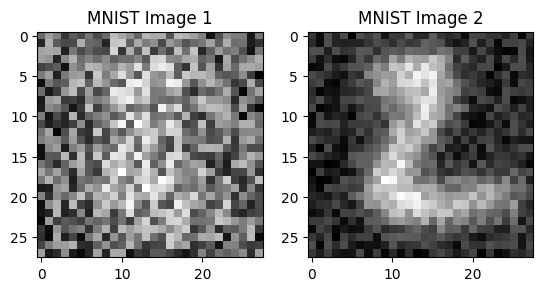

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [49]:
import matplotlib.pyplot as plt

level = 2
item = 1

plt.subplot(1, 2, 1)
plt.imshow((x_test[level][item]*255).reshape(28, 28), cmap='gray')
plt.title('MNIST Image 1')

plt.subplot(1, 2, 2)
plt.imshow((y_test[level][item]*255).reshape(28, 28), cmap='gray')
plt.title('MNIST Image 2')

plt.show()


print(l_test[level][1])

In [50]:
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

from keras import layers, models

def layerGroup():
    noise_input = layers.Input(shape=(28 * 28,))
    label_input = layers.Input(shape=(10,))  # Assuming 10 classes for digits 0-9

    # Concatenate noise input with label
    concatenated_input = layers.concatenate([noise_input, label_input])

    x = layers.Dense(28*28, activation='relu')(concatenated_input)
    x = layers.Dense(28*28, activation='relu')(x)
    generated_image = layers.Dense(28*28)(x)

    model = models.Model(inputs=[noise_input, label_input], outputs=generated_image)

    model.compile(optimizer='adam', loss='mse')  # Use appropriate loss function

    return model

chunks = []
for i in tqdm(range(len(x_test))):
    current = layerGroup()
    current.fit([x_train[i],l_train[i]], y_train[i], epochs=10, batch_size=128,verbose=False)  # Adjust epochs and batch_size
    chunks.append(current)

100%|██████████| 4/4 [00:28<00:00,  7.00s/it]


In [52]:
def finalModel(chunks):
    noise_input = layers.Input(shape=(28 * 28,))
    label_input = layers.Input(shape=(10,))  # Assuming 10 classes for digits 0-9

    # Concatenate noise input with label
    x = None

    for chunk in chunks:
        if x == None:
            x = layers.concatenate([noise_input, label_input])
        else:
            x = layers.concatenate([x, label_input])
            
        x = layers.Dense(28*28, activation='relu')(x)
        x = layers.Dense(28*28, activation='relu')(x)
        x = layers.Dense(28*28)(x)

    model = models.Model(inputs=[noise_input, label_input], outputs=x)

    model.compile(optimizer='adam', loss='mse')  # Use appropriate loss function

    for i in range(len(chunks)):
        index = i*4
        model.layers[index+3].set_weights(chunks[i].layers[3].get_weights())
        model.layers[index+4].set_weights(chunks[i].layers[4].get_weights())
        model.layers[index+5].set_weights(chunks[i].layers[5].get_weights())

    return model

model = finalModel(chunks)
# model.summary()

# s = ""
# for item in model.layers:
#     s+=str(len(item.get_weights()))+", "
# print(s)

In [11]:
# model.fit([x_train[0],l_train[0]], y_train[10], epochs=10, batch_size=128)  # this bad

Epoch 1/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0677
Epoch 2/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0537
Epoch 3/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0536
Epoch 4/10
469/469 [==============================] - 3s 5ms/step - loss: 0.0536
Epoch 5/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0536
Epoch 6/10
469/469 [==============================] - 3s 5ms/step - loss: 0.0536
Epoch 7/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0535
Epoch 8/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0535
Epoch 9/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0535
Epoch 10/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0535


In [53]:
# model.save_weights("split-distillation/split-distillation")
# model.load_weights("split-distilaiton/ssplit-distillation")

# model.save("diffusion-constant-with-blur")


INFO:tensorflow:Assets written to: diffusion-constant-with-blur\assets


In [54]:
import tensorflow as tf
model = tf.keras.models.load_model("diffusion-constant-with-blur")

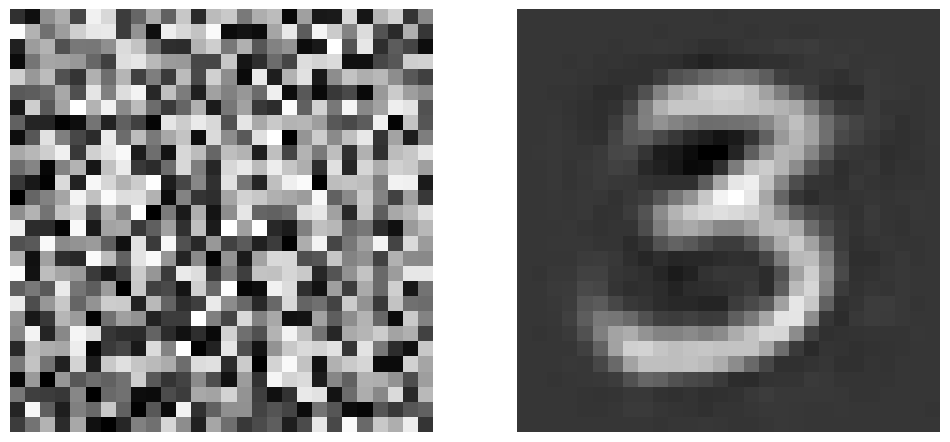

In [58]:
import matplotlib.pyplot as plt
import numpy as np

def generateInput(weigth, number):
    image = np.array([np.random.rand(784)])
    label = np.array([[number if i == weigth else 0 for i in range(10)]])
    return [image, label]


input = generateInput(3,2)

fig, axs = plt.subplots(1, 2, figsize=(12, 6), squeeze=False)
axs[0, 0].imshow(input[0].reshape(28,28).astype('float'), cmap='gray')
axs[0, 1].imshow(model.predict(input,verbose=False).reshape(28, 28).astype('float'), cmap='gray')
for ax in axs[0]:
    ax.axis('off')

plt.show()

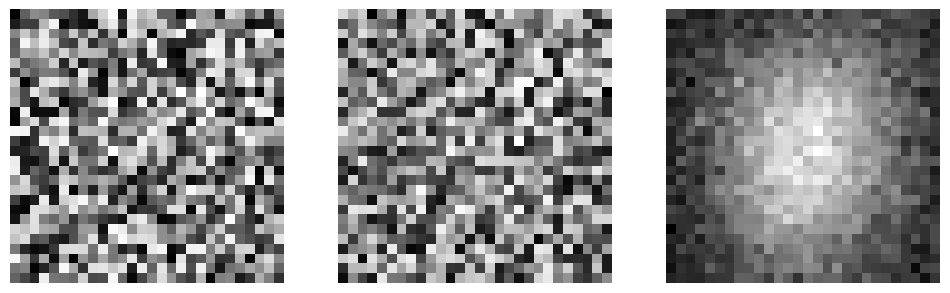

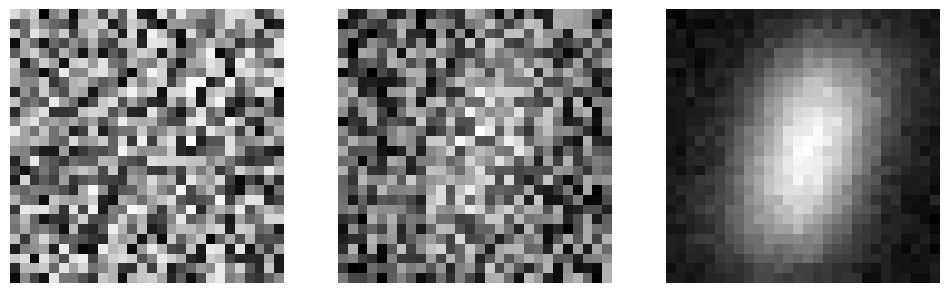

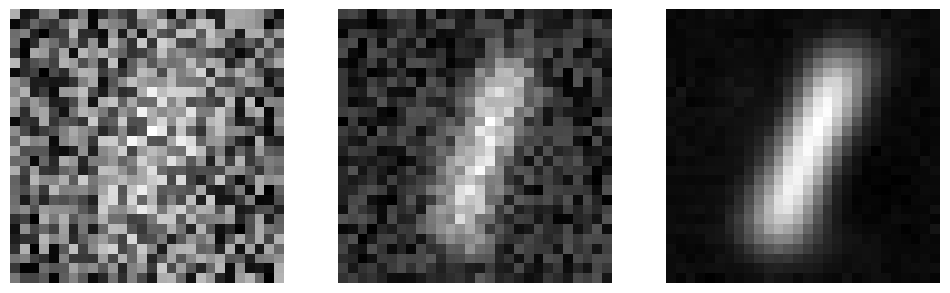

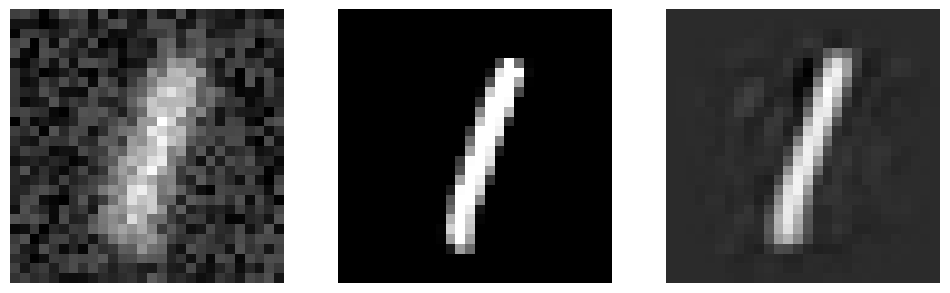

In [56]:

item = 5
level = 1

for level in range(4):
    fig, axs = plt.subplots(1,3, figsize=(12, 6), squeeze=False)
    axs[0, 0].imshow(x_test[level][item].reshape(28,28).astype('float'), cmap='gray')
    axs[0, 1].imshow(y_test[level][item].reshape(28,28).astype('float'), cmap='gray')
    axs[0, 2].imshow(chunks[level].predict([x_test[level], l_test[level]], verbose=False)[item].reshape(28, 28).astype('float'), cmap='gray')
    for ax in axs[0]:
        ax.axis('off')

    plt.show()